In [21]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from plot_utils import plotCategoricalPerformance
import os
import seaborn as sns
import pandas as pd
from families import family_from_str
from plot_util import EFN_model_df, find_last_ind, get_latest_diagnostics
from efn_util import setup_IO, find_convergence, model_opt_hps

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

basedir = '/Users/sbittner/Documents/efn/';
dir_str = 'dim_sweep'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
exp_fam = 'dirichlet';

datadir = '/Users/sbittner/Documents/efn/results/dim_sweep/';
if (exp_fam == 'dirichlet'):
    Ds = [3, 5, 10, 15];
    give_hint = False;
    scatterR2ylim = [0, 1];
    errovbarR2ylim = scatterR2ylim;
    scatterKLylim = [0, 1];
    errorbarKLylim = scatterKLylim;
elif (exp_fam == 'normal' or exp_fam == 'normal5'):
    Ds = [2, 5, 10, 15];
    give_hint = True;
    scatterR2ylim = [.8, 1];
    errorbarR2ylim = scatterR2ylim;
    scatterKLylim = [0, .5];
    errorbarKLylim = scatterKLylim;
elif (exp_fam == 'inv_wishart'):
    Ds = [4, 9, 16];
    give_hint = True;
    scatterR2ylim = [0, 1];
    errorbarR2ylim = scatterR2ylim;
    scatterKLylim = [0, 10];
    errorbarKLylim = scatterKLylim;
elif (exp_fam == 'prp_tn'):
    Ds = [2, 5, 10, 15, 20];
    give_hint = True;
    scatterR2ylim = [0, 1];
    errorbarR2ylim = scatterR2ylim;
    scatterKLylim = [0, 10];
    errorbarKLylim = scatterKLylim;
elif (exp_fam == 'dir_dir'):
    Ds = [5, 10, 15, 20];
    give_hint = True;
    scatterR2ylim = [0, 1];
    errorbarR2ylim = scatterR2ylim;
    scatterKLylim = [0, 10];
    errorbarKLylim = scatterKLylim;
    
num_Ds = len(Ds);
        
num_ds = 10;
K = 100;
M = 1000;
param_net_hps = {'L':4};
stochastic_eta = True;




In [24]:
diagnostic_list = [];
Ds_list = [];
rs = 0;
wsize = 50;
delta_thresh = 1e-10;

max_iters = 1000000;
min_iters = 50000;
check_rate = 100;
max_checks = np.int(max_iters // check_rate);
min_checks = np.int(min_iters // check_rate);

models = ['EFN', 'NF1', 'EFN1'];
num_models = len(models);

mean_elbos_all = [];
std_elbos_all = [];
mean_R2s_all = [];
std_R2s_all = [];
mean_KLs_all = [];
std_KLs_all = [];
final_inds_all = [];
for ii in range(num_models):
    model = models[ii];
    if (model == 'EFN'):
        _num_ds = 1;
    else:
        _num_ds = num_ds;
        
    elbos_all = np.zeros((num_Ds, _num_ds, K));
    R2s_all = np.zeros((num_Ds, _num_ds, K));
    KLs_all = np.zeros((num_Ds, _num_ds, K));
    
    mean_elbos = np.zeros((num_Ds, num_ds, max_checks));
    std_elbos = np.zeros((num_Ds, num_ds, max_checks));
    mean_R2s = np.zeros((num_Ds, num_ds, max_checks));
    std_R2s = np.zeros((num_Ds, num_ds, max_checks));
    mean_KLs = np.zeros((num_Ds, num_ds, max_checks));
    std_KLs = np.zeros((num_Ds, num_ds, max_checks));
    final_inds = np.zeros((num_Ds, num_ds));
    for i in range(num_Ds):
        D = Ds[i];

        fam_class = family_from_str(exp_fam);
        family = fam_class(D);
        
        TIF_flow_type, nlayers, lr_order = model_opt_hps(exp_fam, D);

        for ds in range(_num_ds):
            flow_dict = {'latent_dynamics':None, \
                         'TIF_flow_type':TIF_flow_type, \
                         'repeats':nlayers};
            dist_info = {'dist_seed':ds};
            savedir = basedir + setup_IO(family, model, dir_str, 'eta', K, M, flow_dict, param_net_hps, \
                                         stochastic_eta, give_hint, rs, dist_info);
            fname = savedir + 'results.npz';
            try:
                npzfile = np.load(fname);
            except:
                print('issue reading %s' % fname);
                continue

            test_elbos = npzfile['test_elbos'];
            last_ind = find_last_ind(test_elbos);
            mean_test_elbos = np.mean(test_elbos, 1);
            ind = find_convergence(mean_test_elbos, last_ind+1, wsize, delta_thresh);
            if (ind is None or (not npzfile['converged'])):
                print('Hasnt converged: %s' % fname);
                final_inds[i, ds] = None;
                continue;
            else:
                print(fname);
                print('before ind: %d' % ind);
                ind = max(ind, min_checks);
                print('after ind: %d' % ind);
                final_inds[i, ds] = ind;
            
            diagnostic_str = 'train' if (model == 'EFN1') else 'test';
            mean_elbos[i,ds,:ind] = np.mean(npzfile['%s_elbos' % diagnostic_str], 1)[:ind];
            std_elbos[i,ds,:ind] = np.std(npzfile['%s_elbos' % diagnostic_str], 1)[:ind];
            mean_R2s[i,ds,:ind] = np.mean(npzfile['%s_R2s' % diagnostic_str], 1)[:ind];
            std_R2s[i,ds,:ind] = np.std(npzfile['%s_R2s' % diagnostic_str], 1)[:ind];
            mean_KLs[i,ds,:ind] = np.mean(npzfile['%s_KLs' % diagnostic_str], 1)[:ind];
            std_KLs[i,ds,:ind] = np.std(npzfile['%s_KLs' % diagnostic_str], 1)[:ind];
                
            elbos, R2s, KLs, status = get_latest_diagnostics(fname, is_train=(model=='EFN1'));

            elbos_all[i, ds,:] = elbos;
            R2s_all[i, ds,:] = R2s;
            KLs_all[i, ds,:] = KLs;
    diagnostic_list.append([elbos_all, R2s_all, KLs_all]);
    Ds_list.append(np.tile(np.expand_dims(np.expand_dims(np.array(Ds), 1), 2), [1, _num_ds, K]));
    
    mean_elbos_all.append(mean_elbos);
    std_elbos_all.append(std_elbos);
    mean_R2s_all.append(mean_R2s);
    std_R2s_all.append(std_R2s);
    mean_KLs_all.append(mean_KLs);
    std_KLs_all.append(std_KLs);
    final_inds_all.append(final_inds);

Hasnt converged: /Users/sbittner/Documents/efn/results/dim_sweep/EFN_dirichlet_stochasticEta_D=3_K=100_M=1000_flow=20P_L=4_rs=0/results.npz
/Users/sbittner/Documents/efn/results/dim_sweep/EFN_dirichlet_stochasticEta_D=5_K=100_M=1000_flow=20P_L=4_rs=0/results.npz
before ind: 451
after ind: 500
/Users/sbittner/Documents/efn/results/dim_sweep/EFN_dirichlet_stochasticEta_D=10_K=100_M=1000_flow=20P_L=4_rs=0/results.npz
before ind: 712
after ind: 712
Hasnt converged: /Users/sbittner/Documents/efn/results/dim_sweep/EFN_dirichlet_stochasticEta_D=15_K=100_M=1000_flow=20P_L=4_rs=0/results.npz
/Users/sbittner/Documents/efn/results/dim_sweep/NF1_dirichlet_D=3_flow=20P_ds=0_rs=0/results.npz

/Users/sbittner/Library/Python/3.6/lib/python/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/sbittner/Library/Python/3.6/lib/python/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



before ind: 186
after ind: 500
/Users/sbittner/Documents/efn/results/dim_sweep/NF1_dirichlet_D=3_flow=20P_ds=1_rs=0/results.npz
before ind: 289
after ind: 500
/Users/sbittner/Documents/efn/results/dim_sweep/NF1_dirichlet_D=3_flow=20P_ds=2_rs=0/results.npz
before ind: 241
after ind: 500
/Users/sbittner/Documents/efn/results/dim_sweep/NF1_dirichlet_D=3_flow=20P_ds=3_rs=0/results.npz
before ind: 225
after ind: 500
/Users/sbittner/Documents/efn/results/dim_sweep/NF1_dirichlet_D=3_flow=20P_ds=4_rs=0/results.npz
before ind: 167
after ind: 500
/Users/sbittner/Documents/efn/results/dim_sweep/NF1_dirichlet_D=3_flow=20P_ds=5_rs=0/results.npz
before ind: 242
after ind: 500
/Users/sbittner/Documents/efn/results/dim_sweep/NF1_dirichlet_D=3_flow=20P_ds=6_rs=0/results.npz
before ind: 236
after ind: 500
/Users/sbittner/Documents/efn/results/dim_sweep/NF1_dirichlet_D=3_flow=20P_ds=7_rs=0/results.npz
before ind: 215
after ind: 500
/Users/sbittner/Documents/efn/results/dim_sweep/NF1_dirichlet_D=3_flow=2

after ind: 500
/Users/sbittner/Documents/efn/results/dim_sweep/EFN1_dirichlet_D=10_flow=20P_ds=5_rs=0/results.npz
before ind: 311
after ind: 500
/Users/sbittner/Documents/efn/results/dim_sweep/EFN1_dirichlet_D=10_flow=20P_ds=6_rs=0/results.npz
before ind: 304
after ind: 500
/Users/sbittner/Documents/efn/results/dim_sweep/EFN1_dirichlet_D=10_flow=20P_ds=7_rs=0/results.npz
before ind: 309
after ind: 500
/Users/sbittner/Documents/efn/results/dim_sweep/EFN1_dirichlet_D=10_flow=20P_ds=8_rs=0/results.npz
before ind: 398
after ind: 500
/Users/sbittner/Documents/efn/results/dim_sweep/EFN1_dirichlet_D=10_flow=20P_ds=9_rs=0/results.npz
before ind: 330
after ind: 500
/Users/sbittner/Documents/efn/results/dim_sweep/EFN1_dirichlet_D=15_flow=20P_ds=0_rs=0/results.npz
before ind: 456
after ind: 500
/Users/sbittner/Documents/efn/results/dim_sweep/EFN1_dirichlet_D=15_flow=20P_ds=1_rs=0/results.npz
before ind: 482
after ind: 500
/Users/sbittner/Documents/efn/results/dim_sweep/EFN1_dirichlet_D=15_flow=20

In [18]:
param_mat_lists = [Ds_list];
param_labels = ['D'];
df, d = EFN_model_df('model', models, param_mat_lists, param_labels, diagnostic_list);


/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


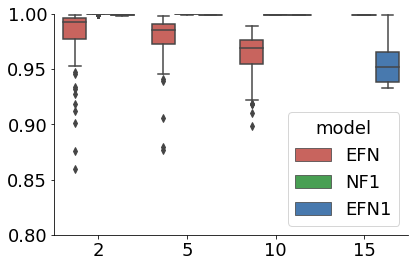

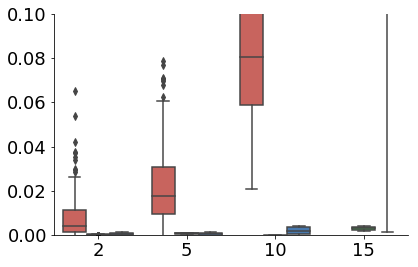

In [19]:
colors = ["pale red", "medium green", "windows blue", "amber", "dusty purple", "greyish", "faded green", "denim blue"];
palette = sns.xkcd_palette(colors)

plt.figure(figsize=(6,4));
ax = sns.boxplot(x='D', y='R2', hue='model', \
                      data=df, palette=palette)
#plt.ylim([.9,1]);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout();
plt.ylim([.8,1]);
plt.savefig('/Users/sbittner/Documents/efn/written/figs/fig3/%s_R2.pdf' % exp_fam, \
            dpi=300, transparent=True)
plt.show();

plt.figure(figsize=(6,4));
ax = sns.boxplot(x='D', y='KL', hue='model',
                      data=df, palette=palette)
ax.legend_.remove()
#plt.ylim([0, .1]);
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout();
plt.ylim([0, .1]);
plt.savefig('/Users/sbittner/Documents/efn/written/figs/fig3/%s_KL.pdf' % exp_fam, \
            dpi=300, transparent=True)
plt.show();

/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


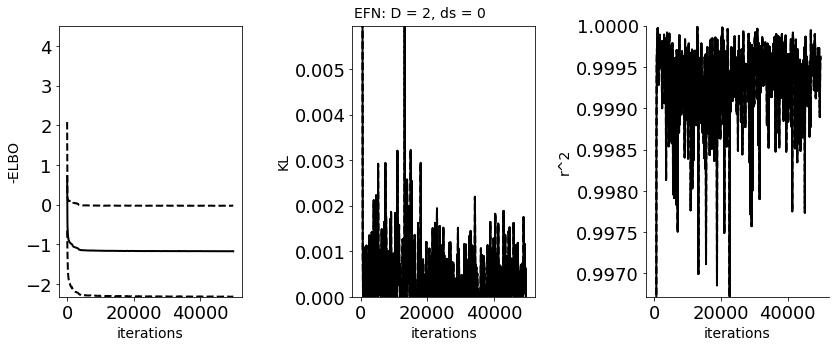

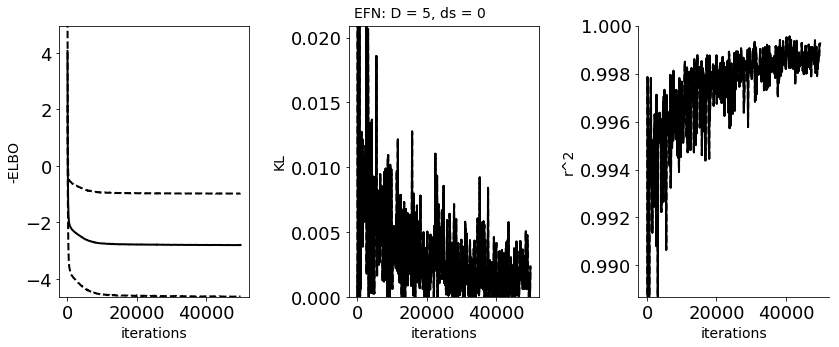

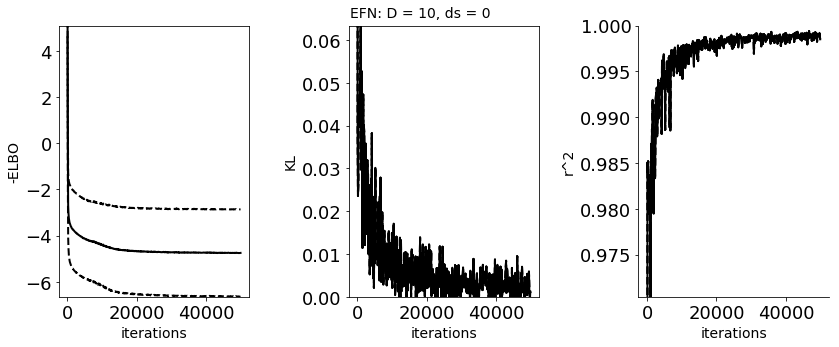

/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


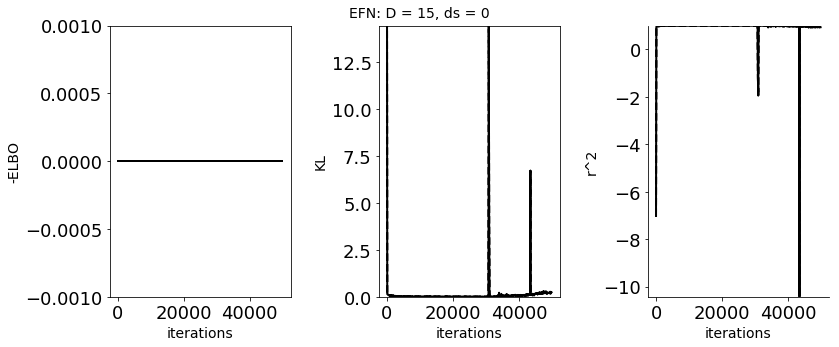

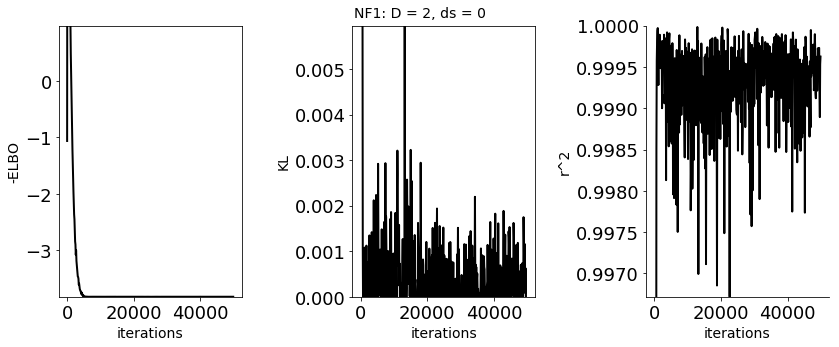

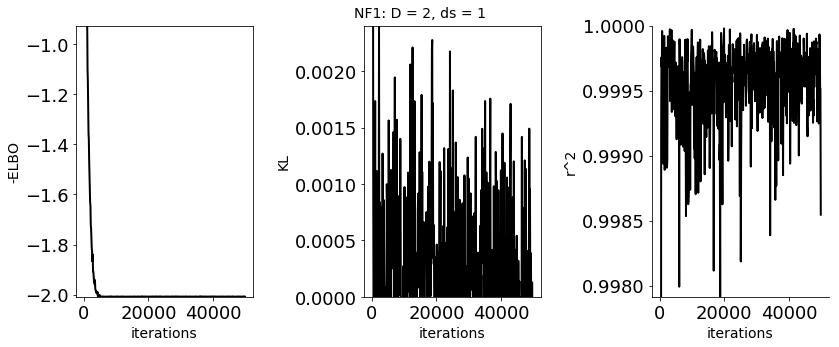

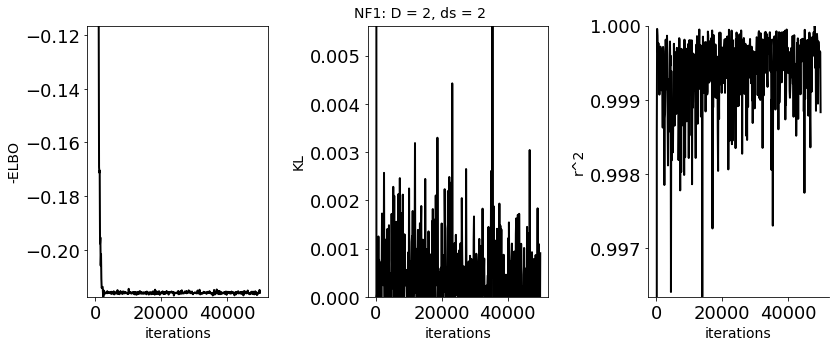

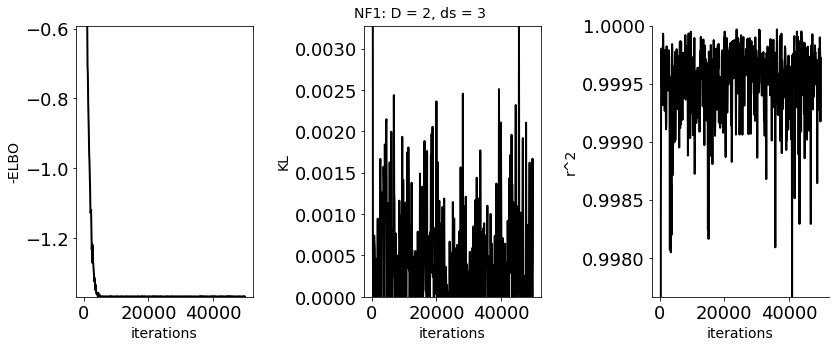

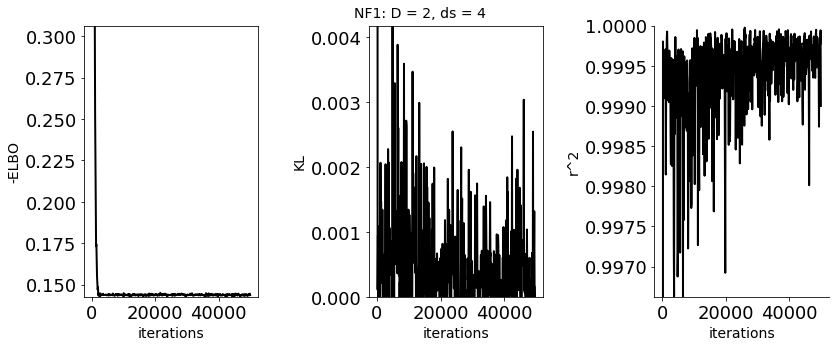

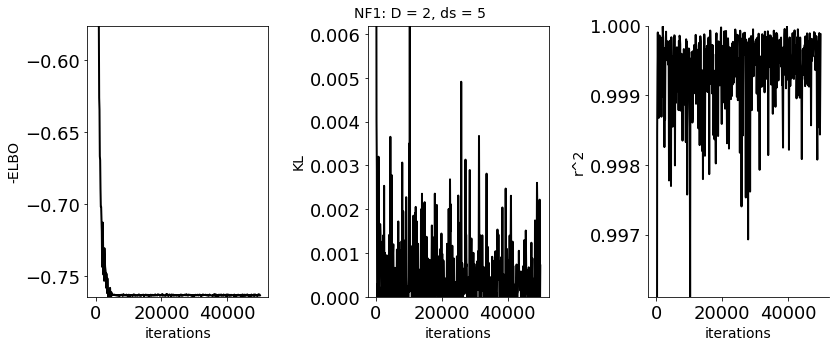

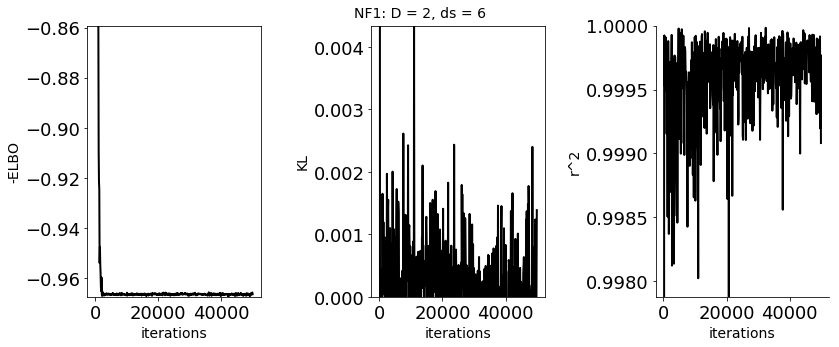

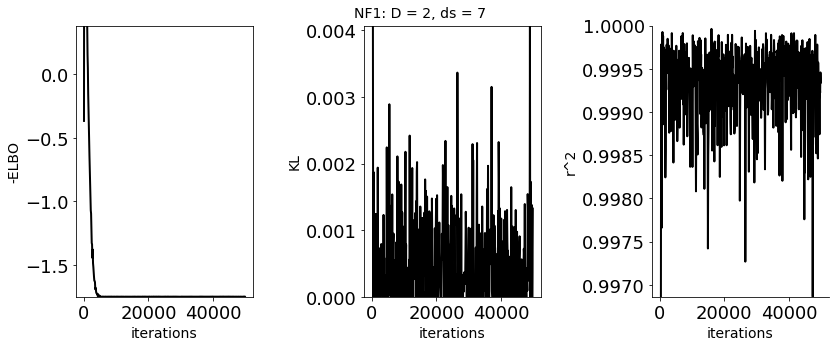

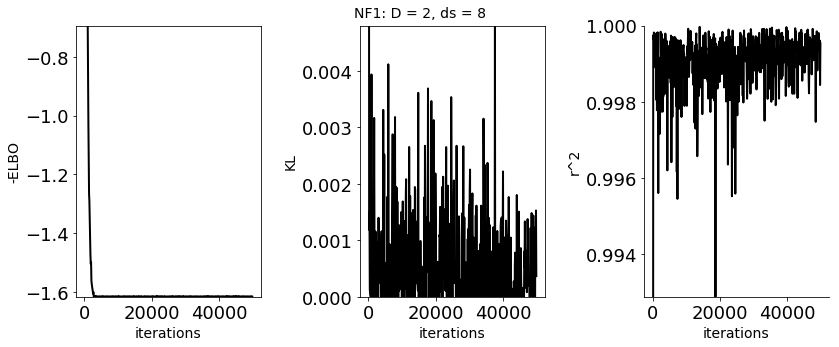

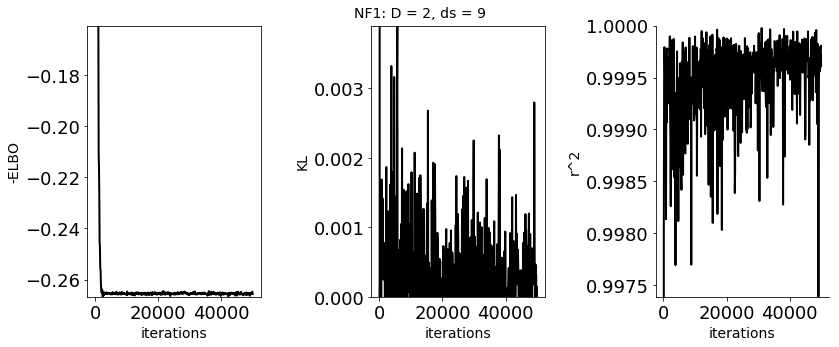

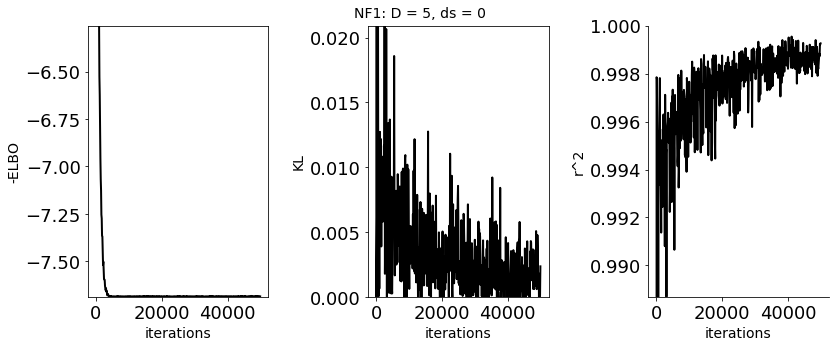

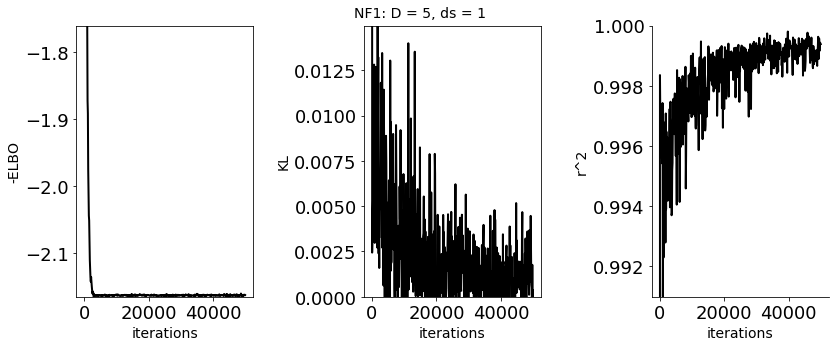

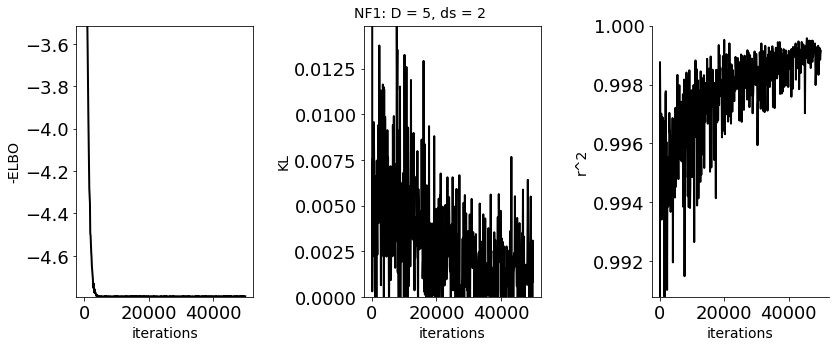

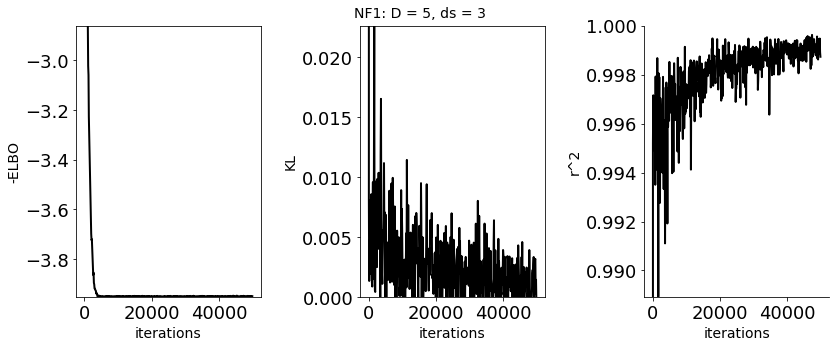

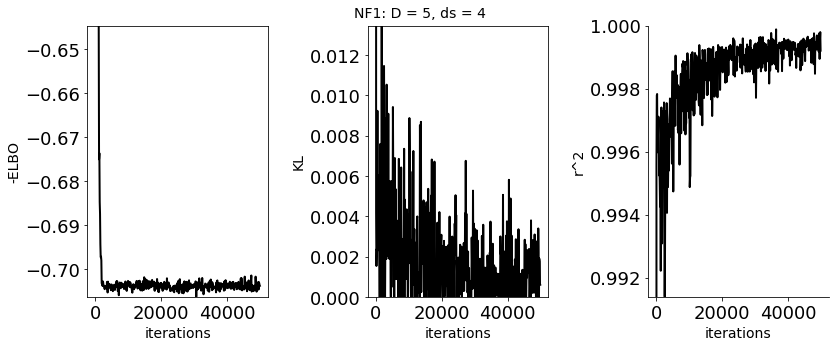

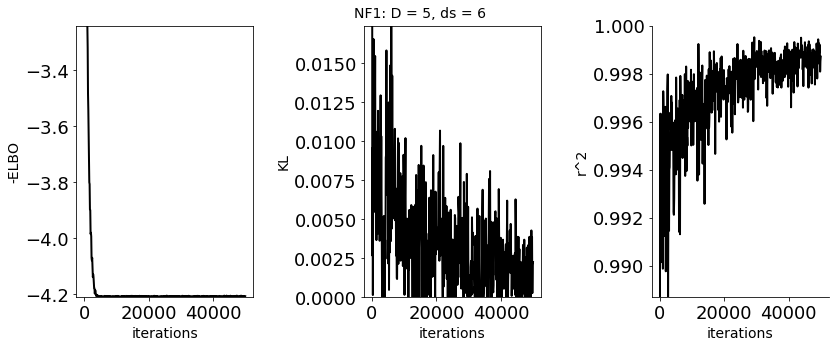

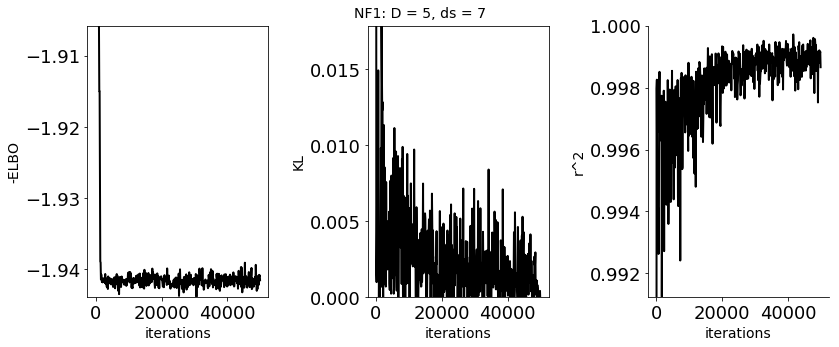

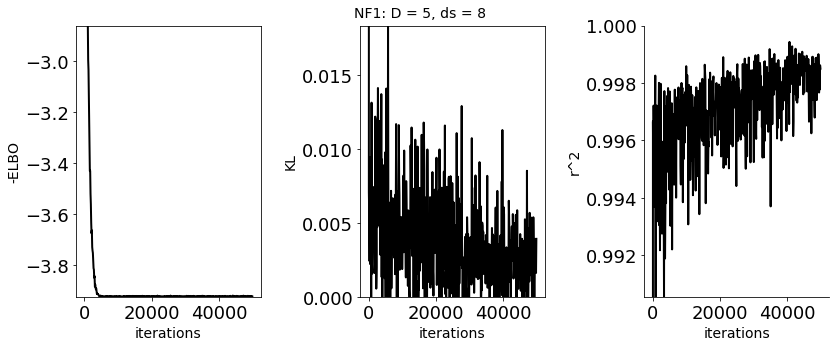

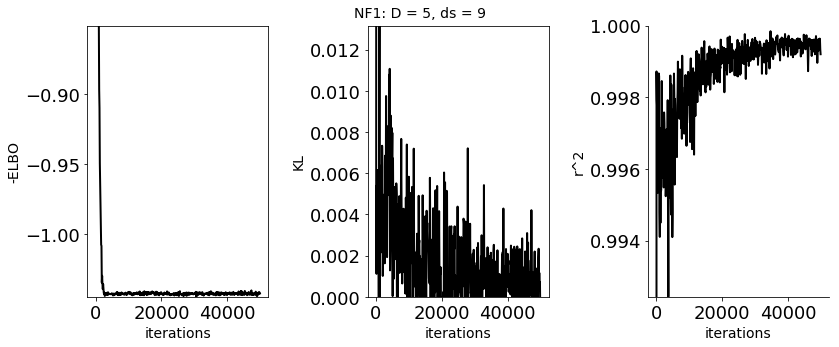

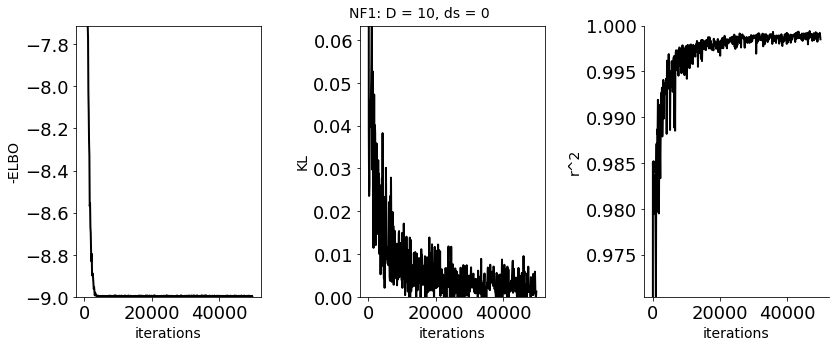

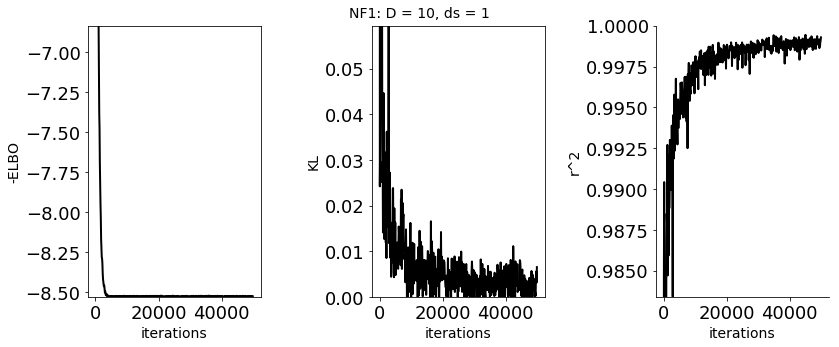

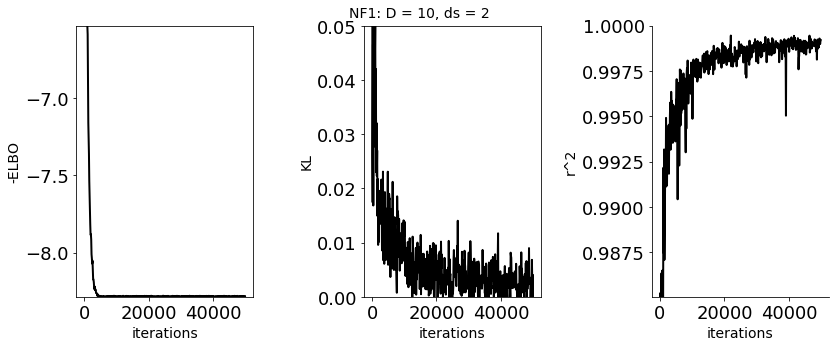

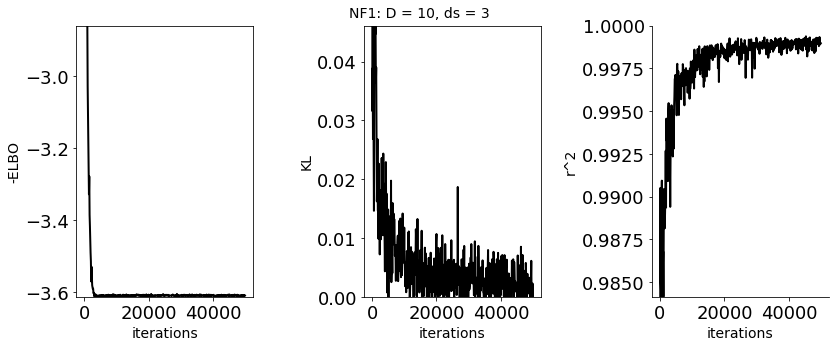

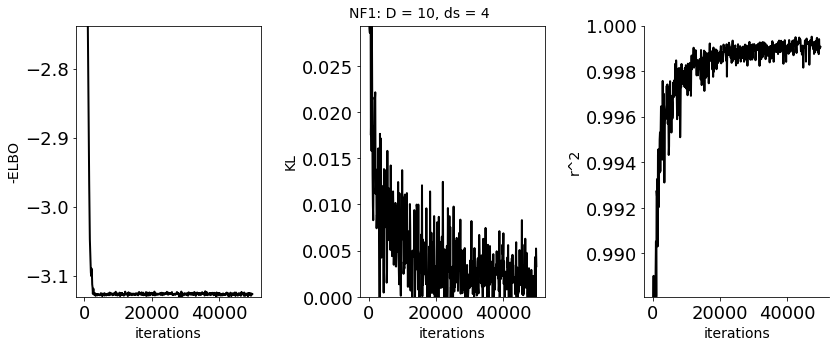

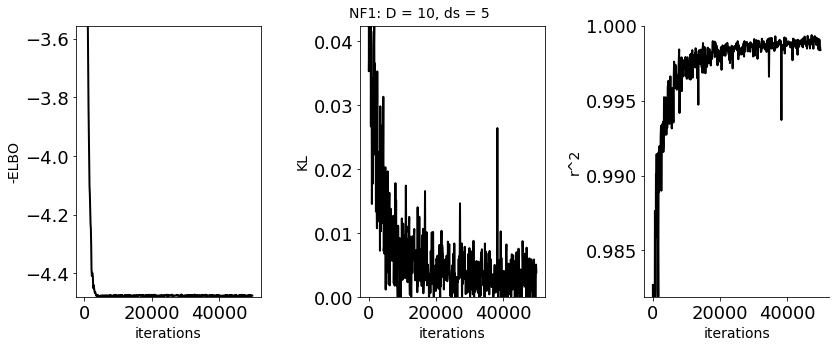

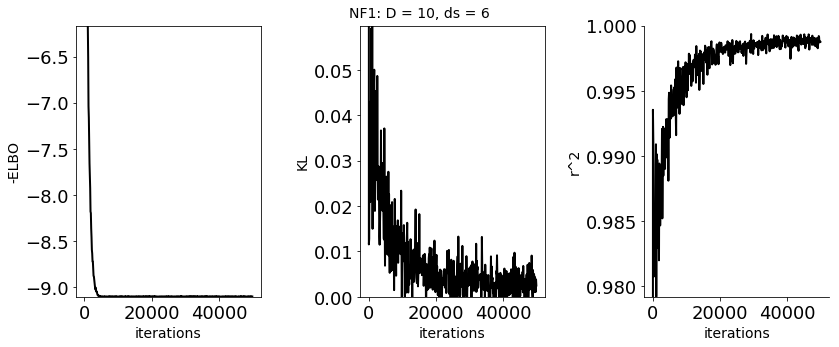

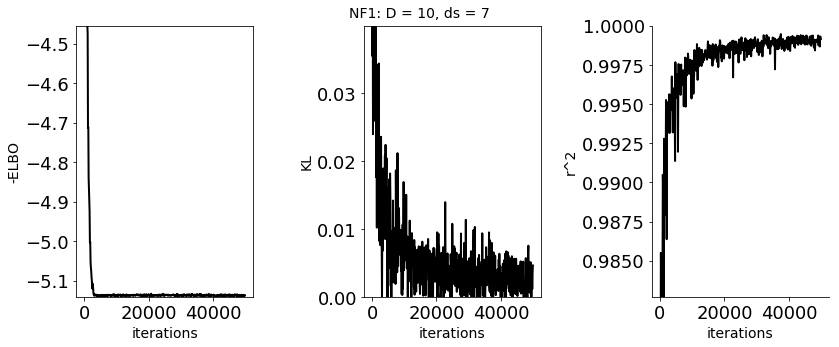

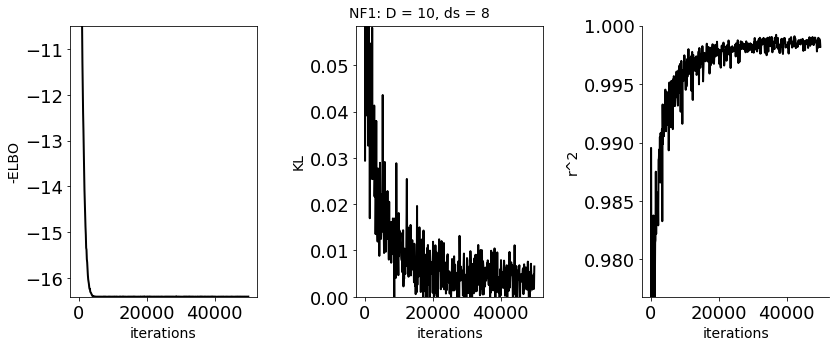

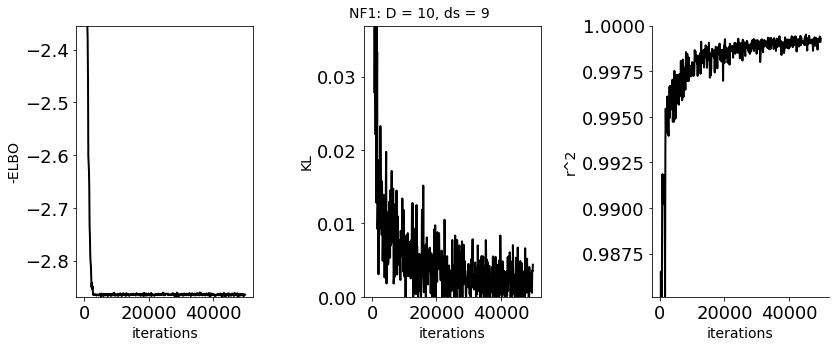

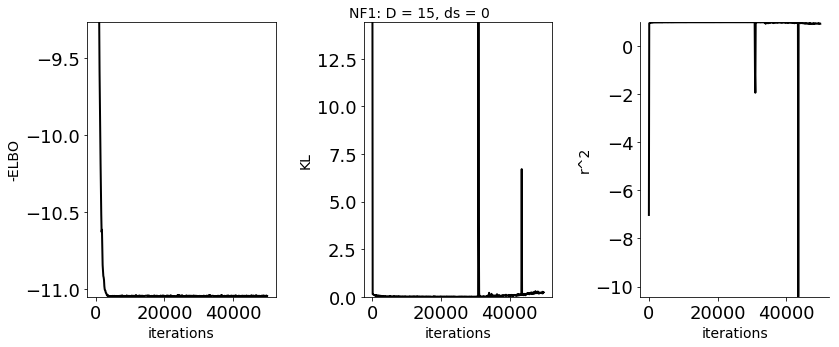

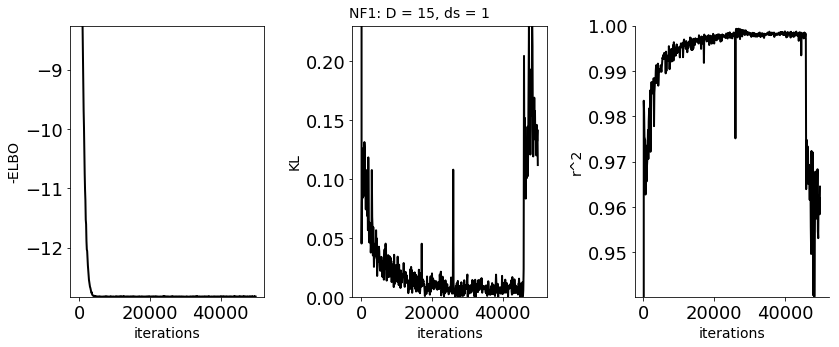

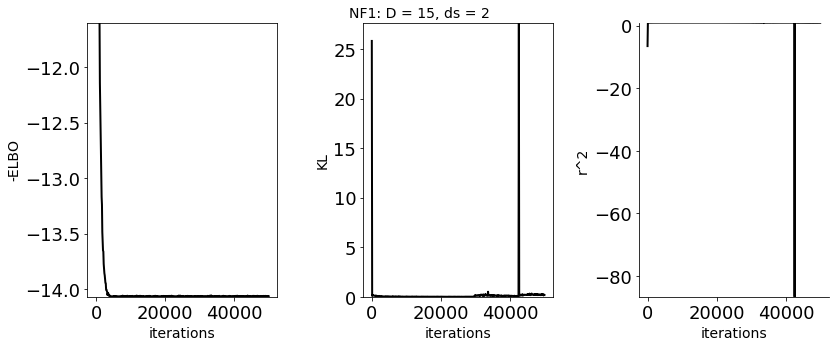

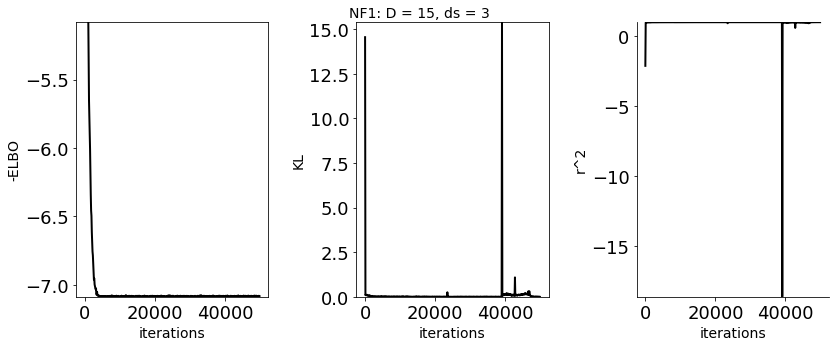

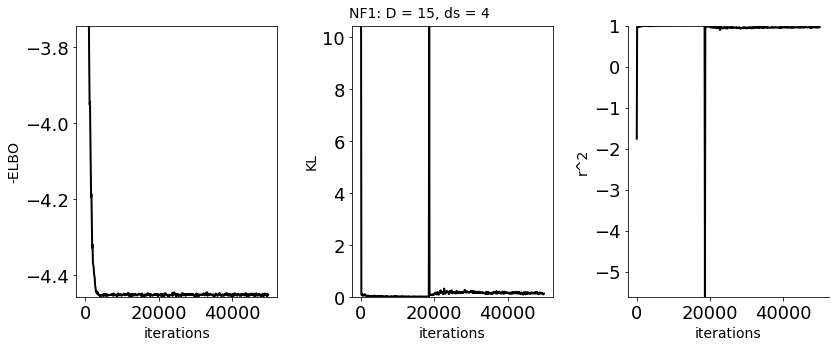

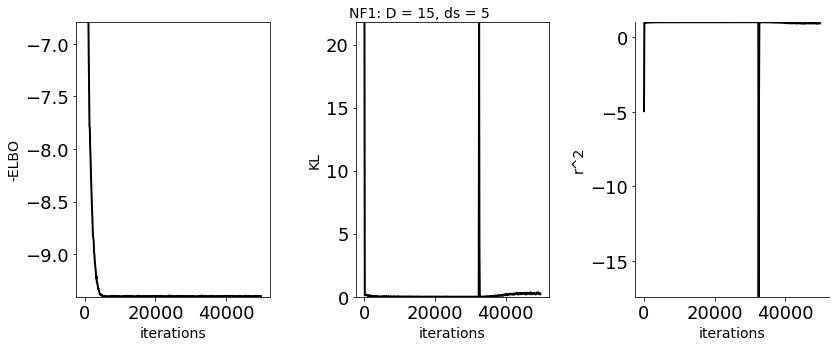

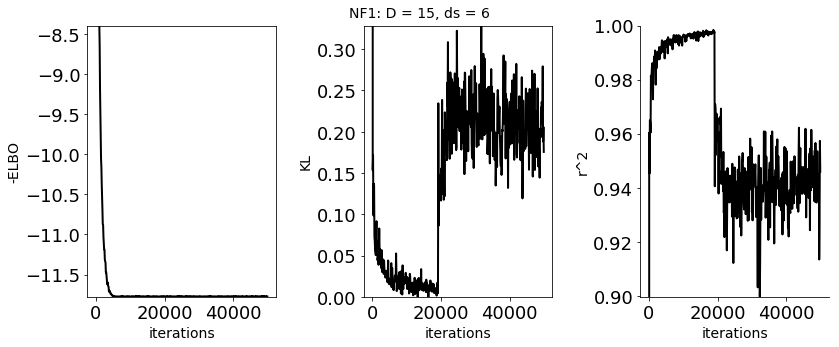

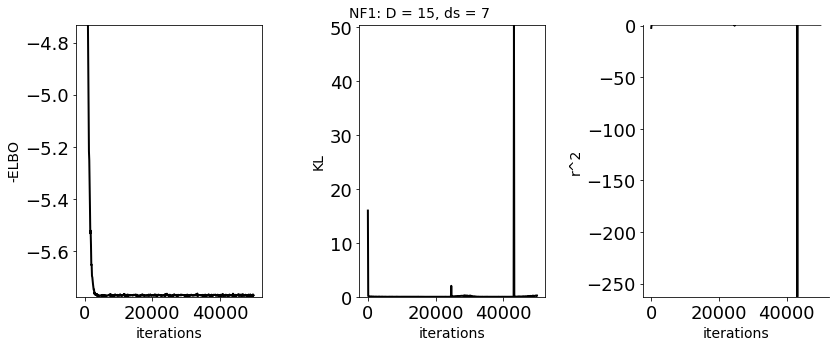

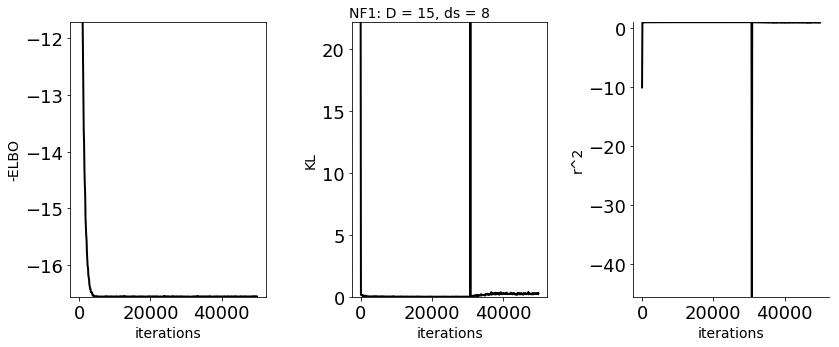

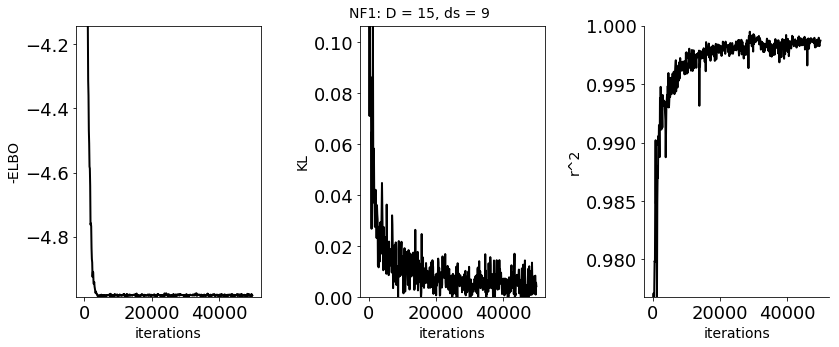

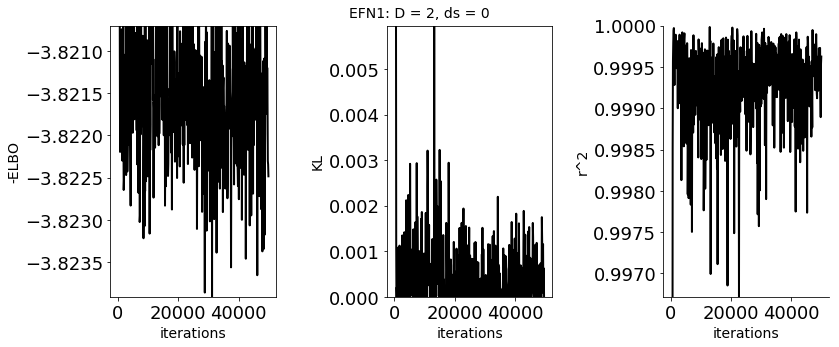

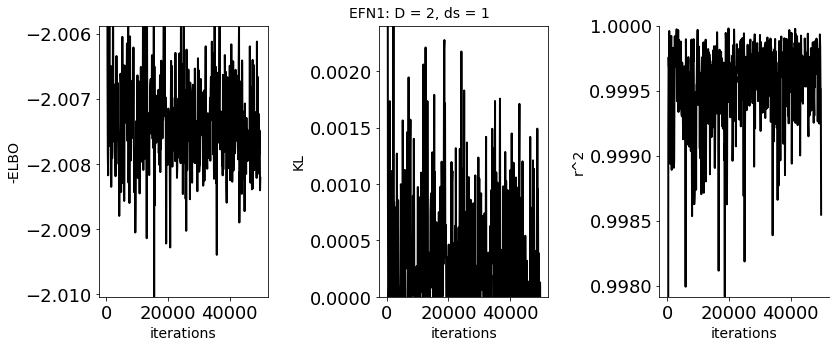

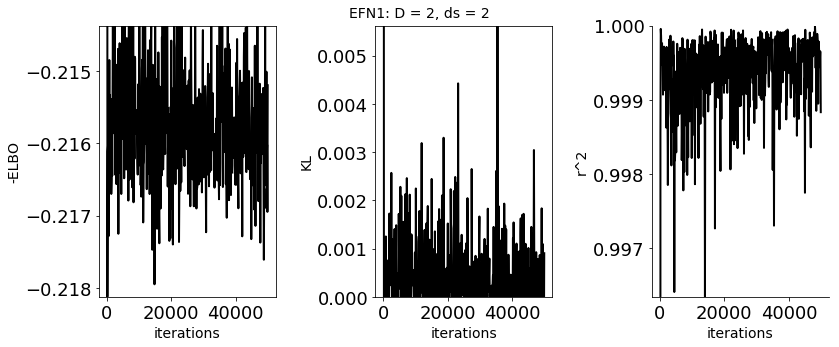

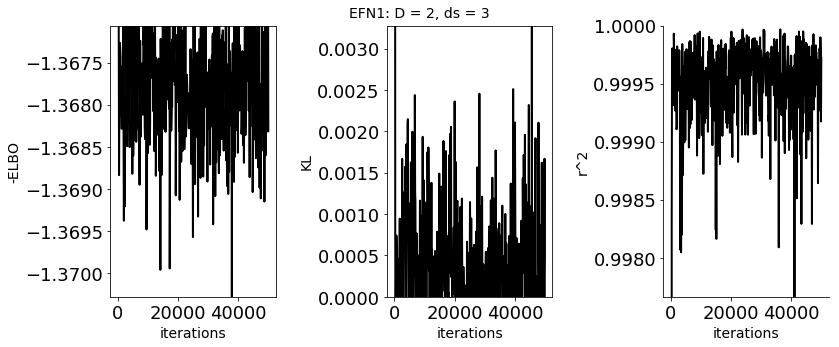

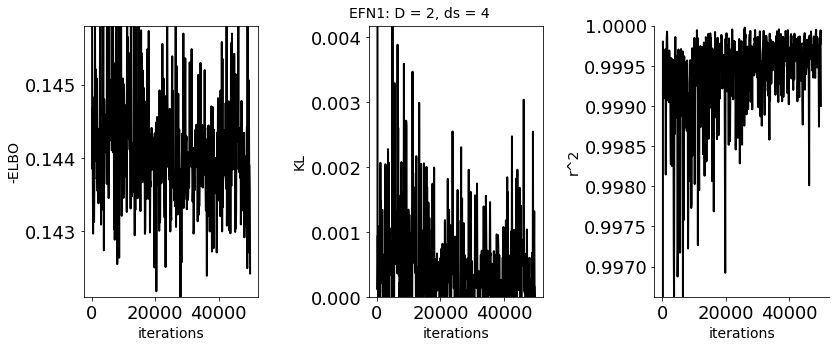

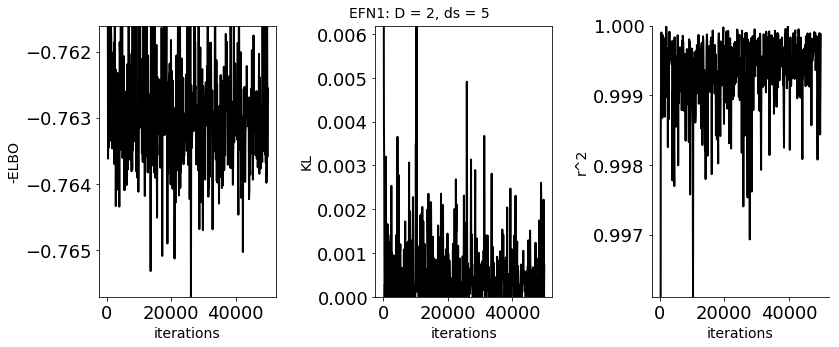

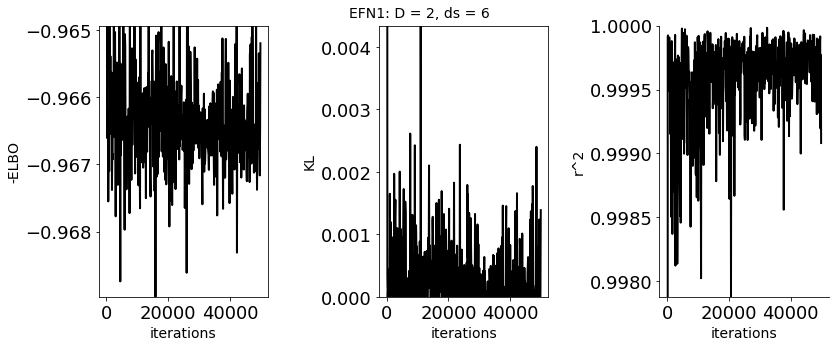

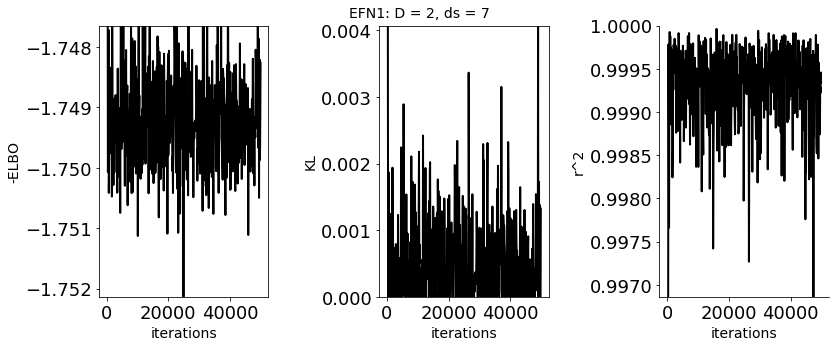

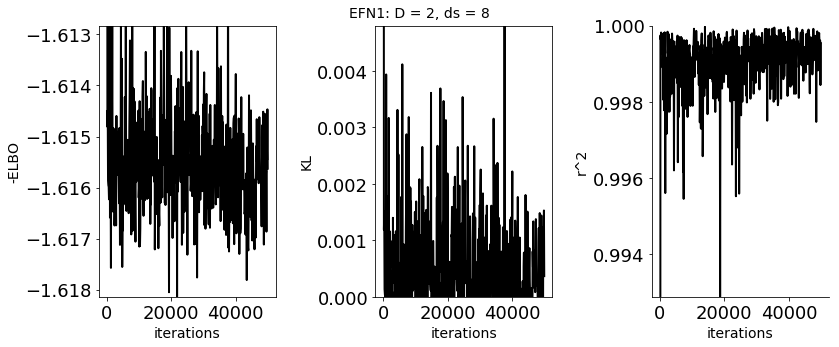

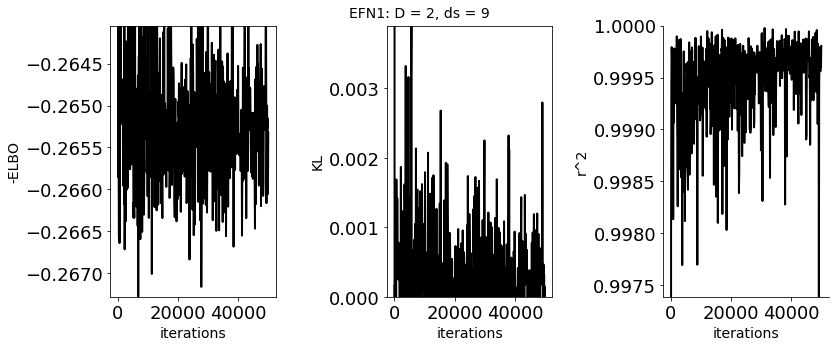

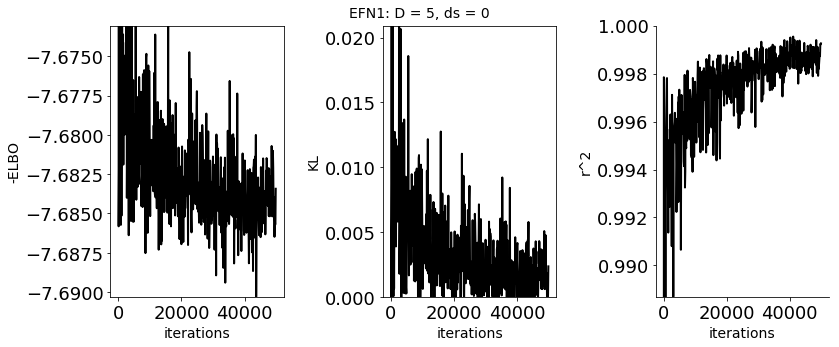

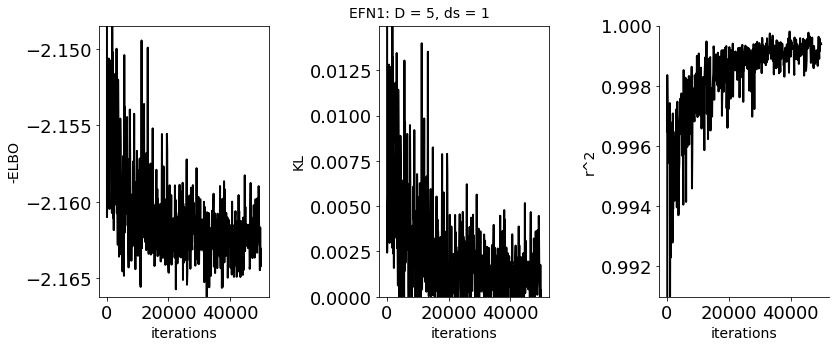

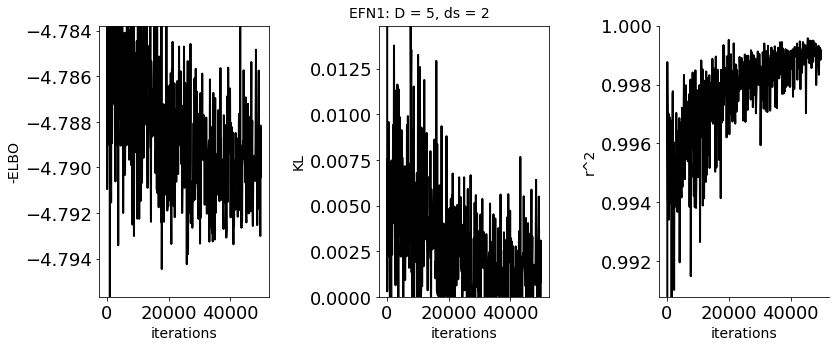

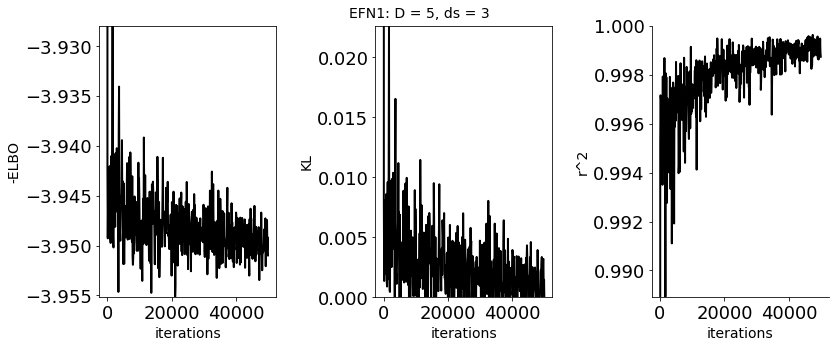

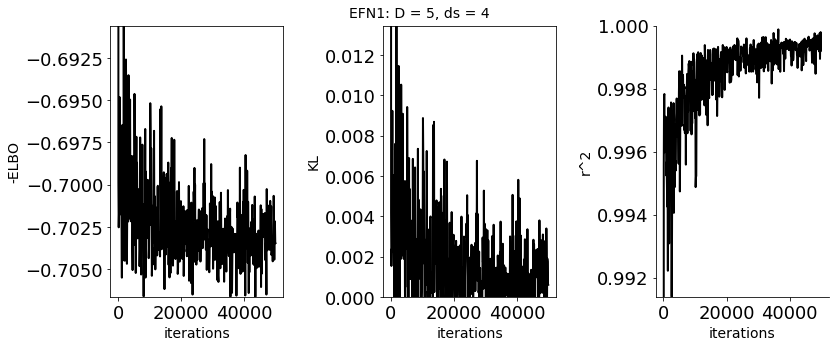

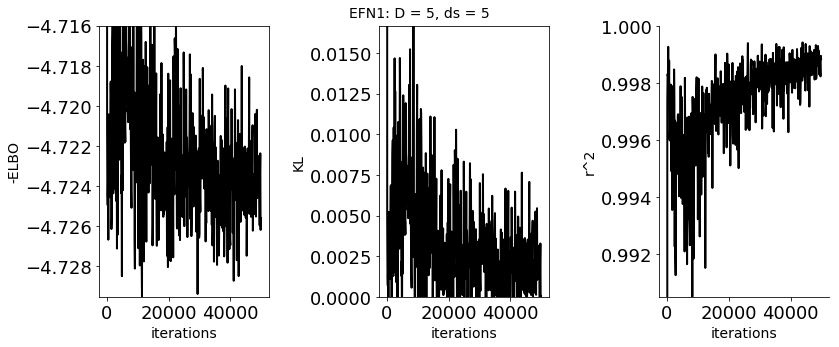

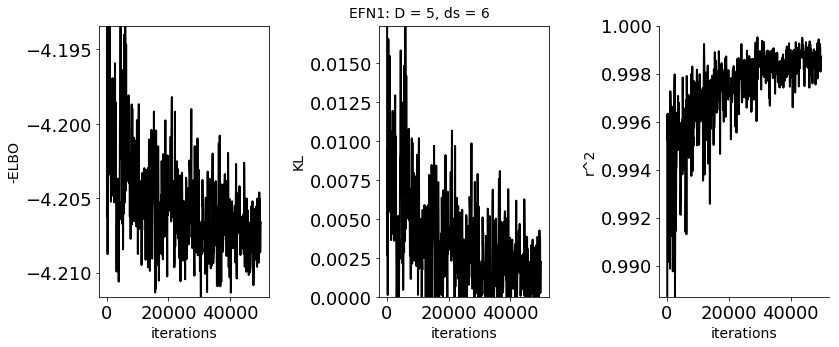

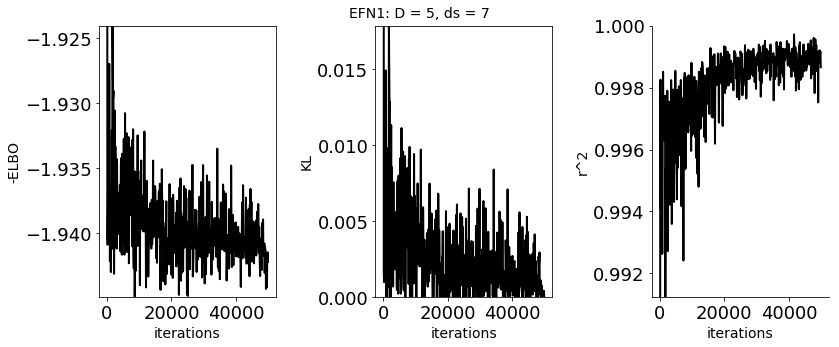

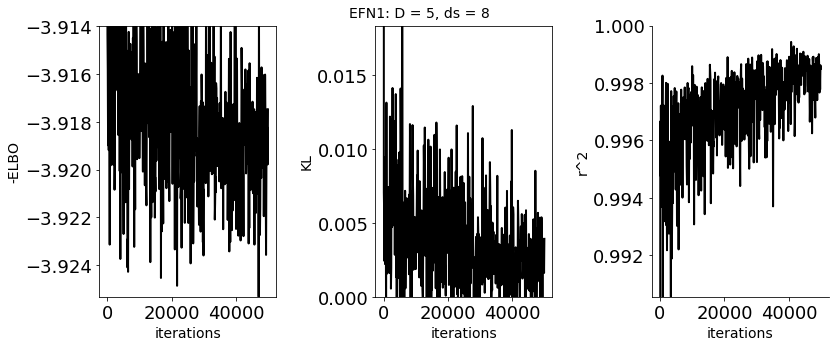

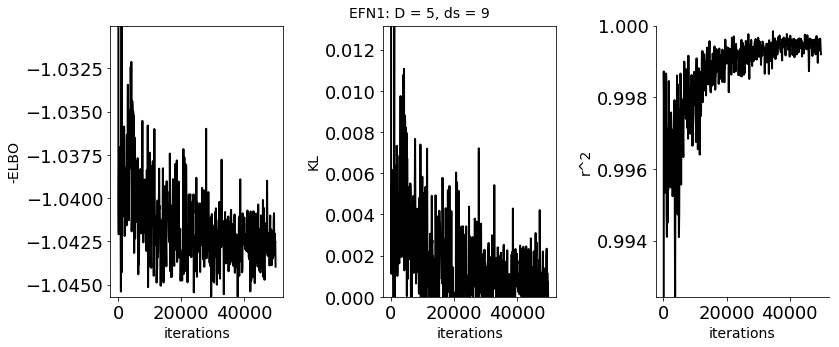

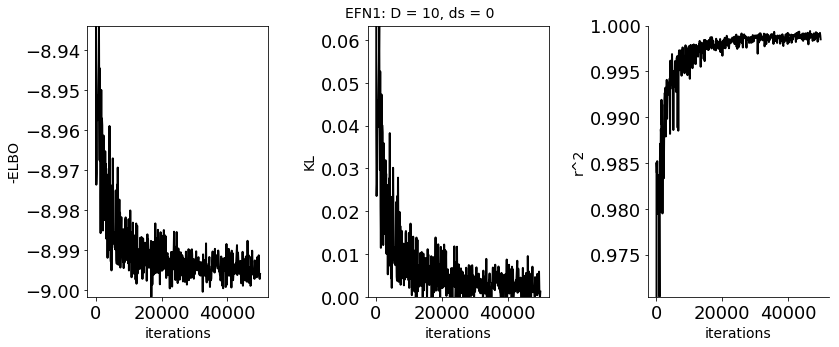

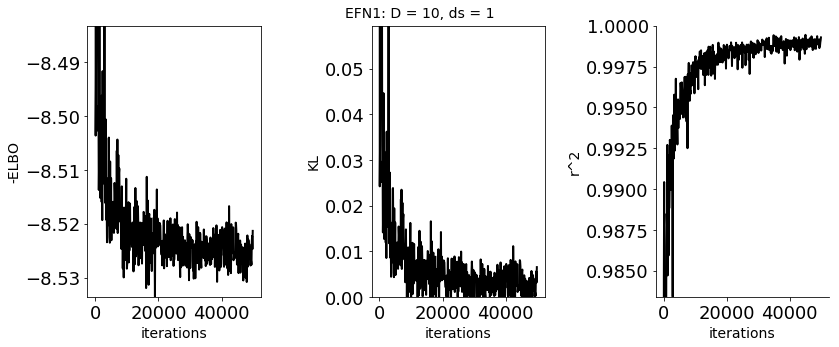

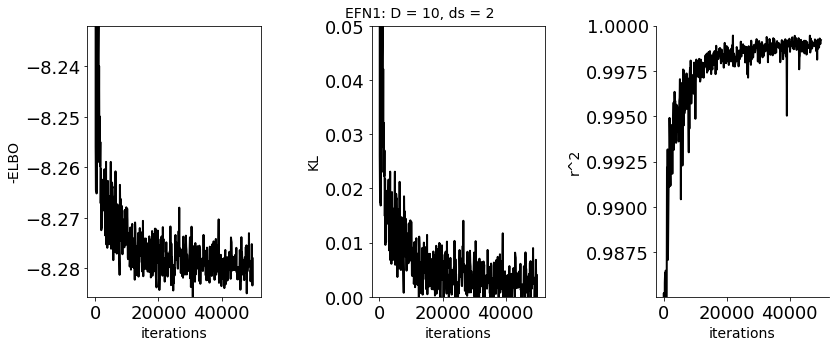

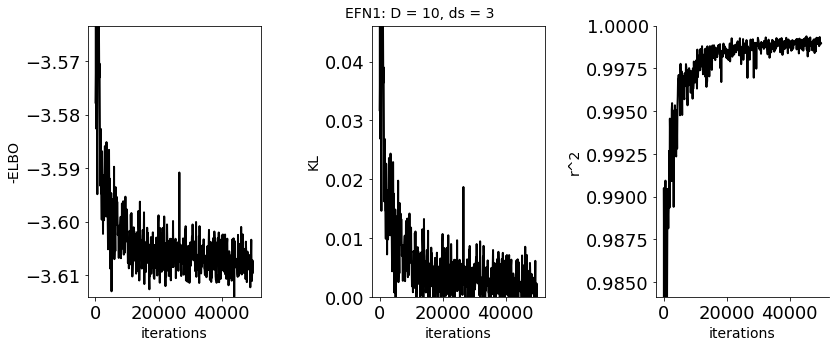

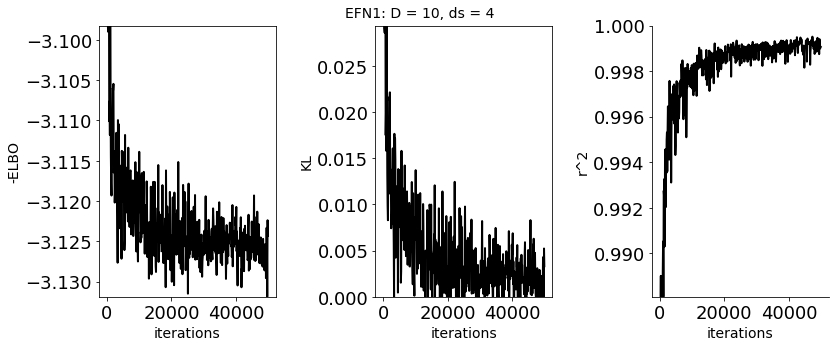

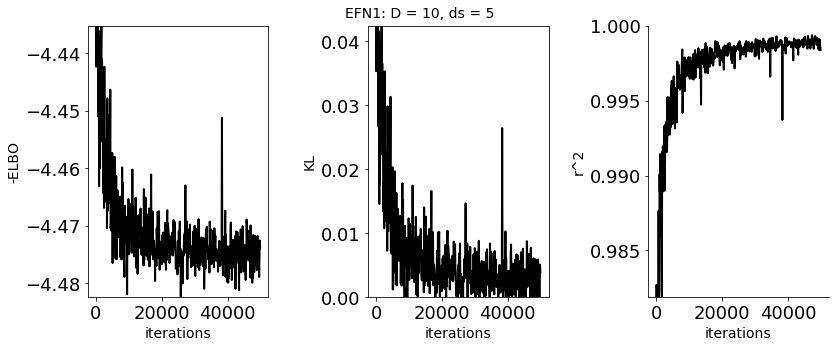

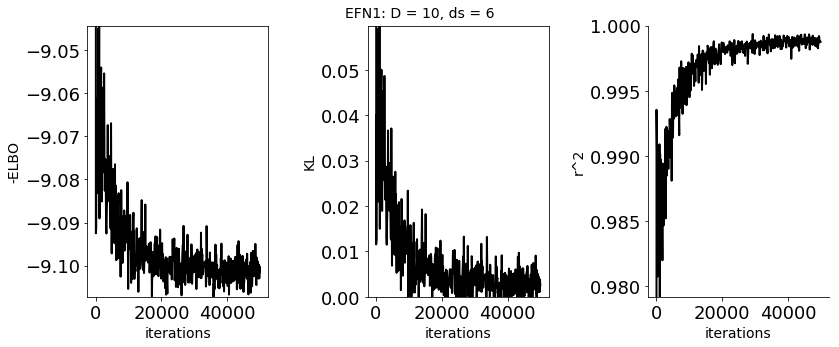

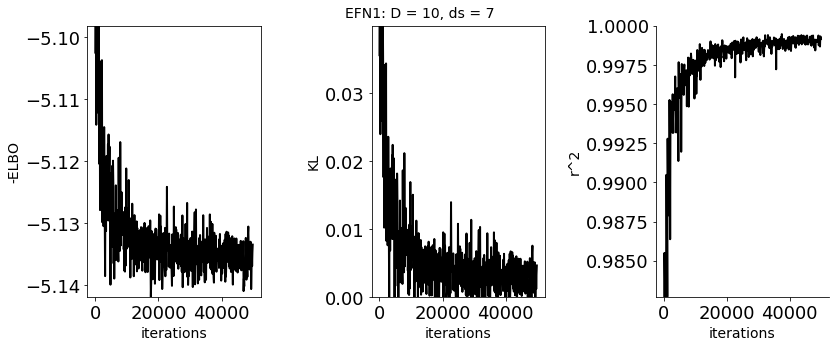

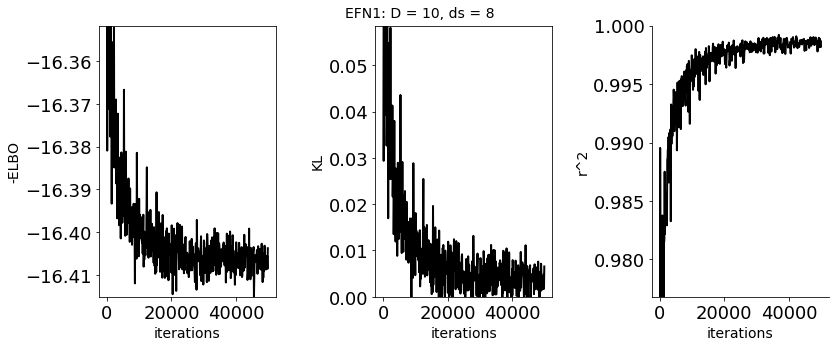

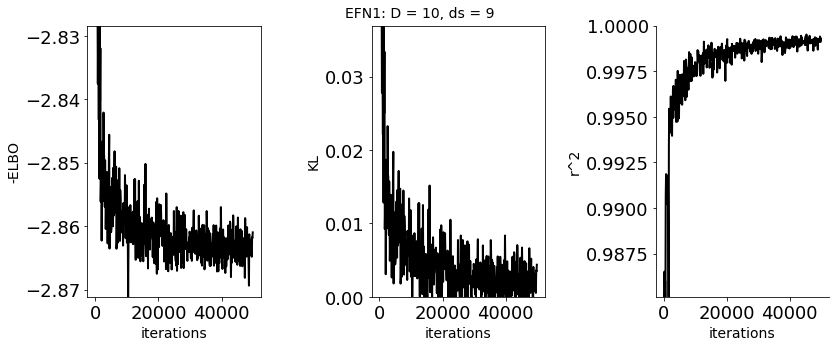

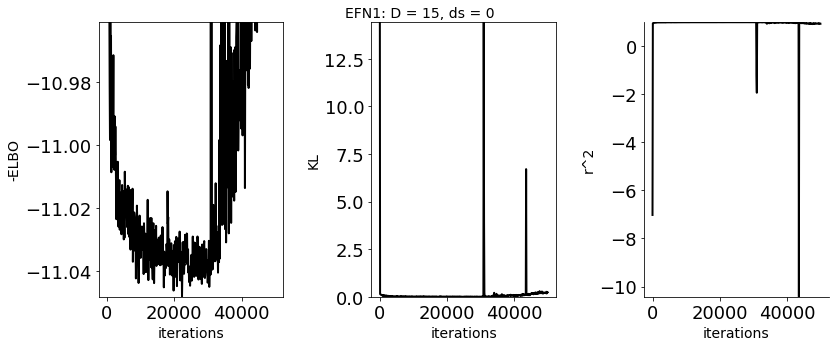

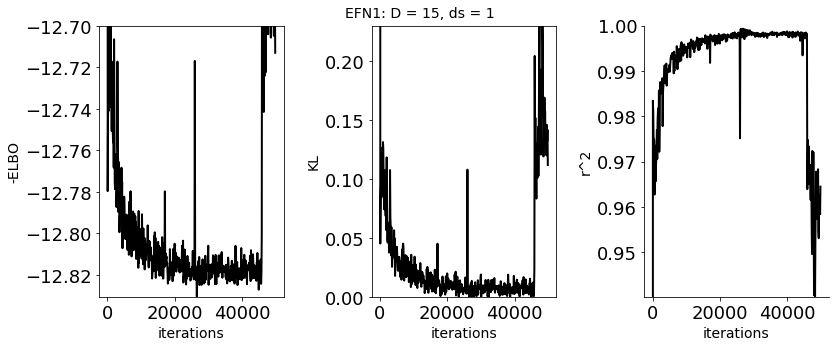

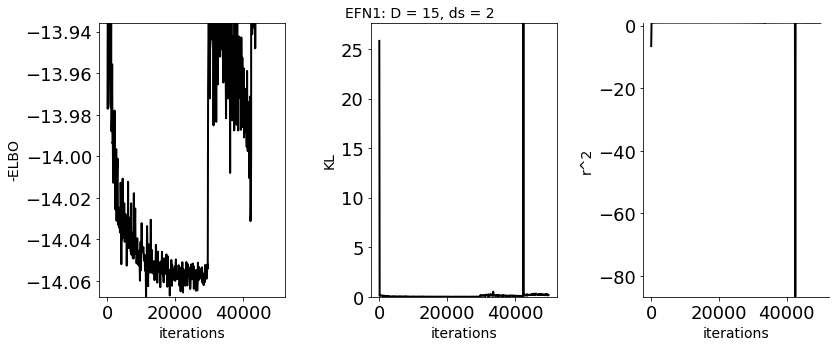

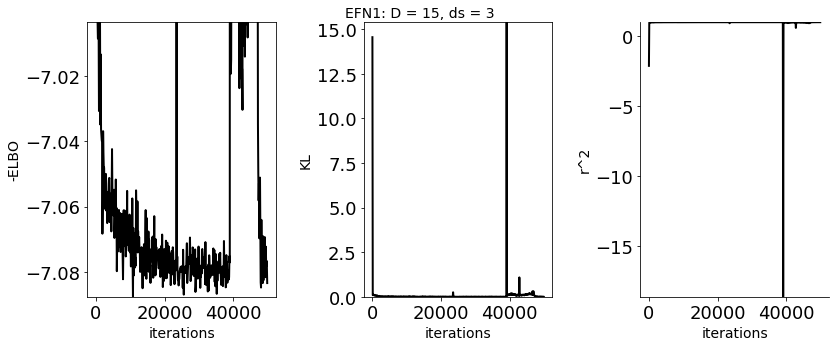

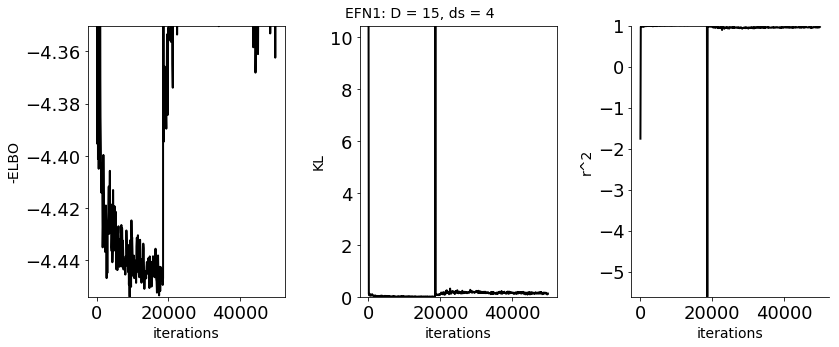

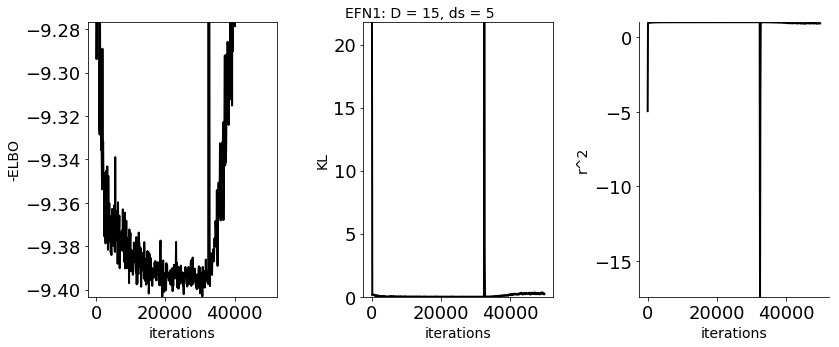

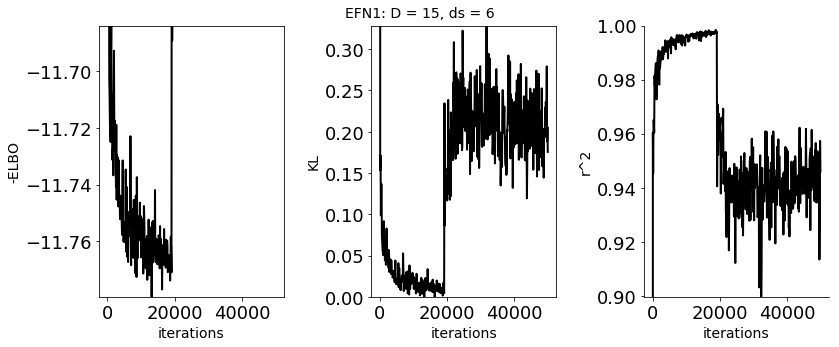

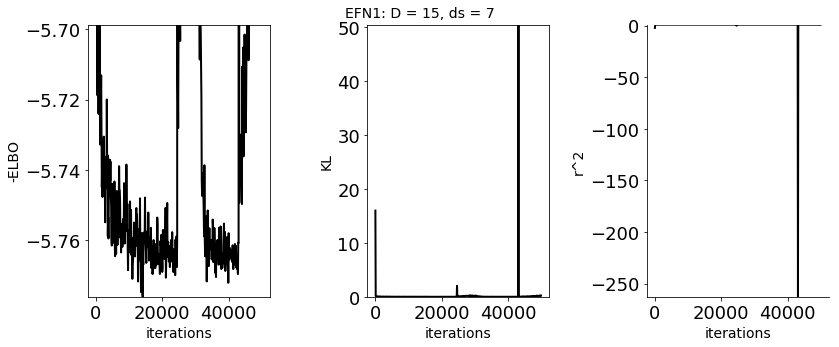

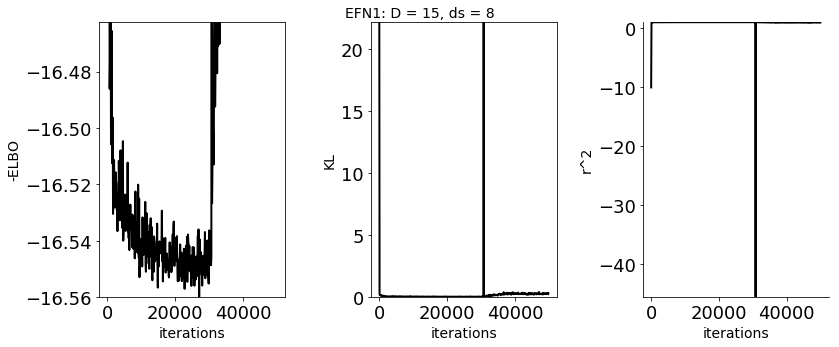

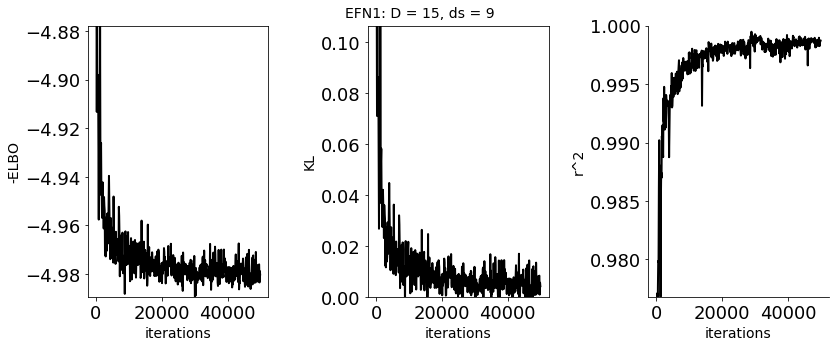

In [20]:
fontsize = 14;
for ii in range(num_models):
    model = models[ii];
    
    if (model == 'EFN'):
        _num_ds = 1;
    else:
        _num_ds = num_ds;
        
    mean_elbos = mean_elbos_all[ii];
    std_elbos = std_elbos_all[ii];
    final_ind = final_inds_all[ii];
    for i in range(num_Ds):
        D = Ds[i];
        for ds in range(_num_ds):
            try:
                plt.figure(figsize=(12,5));
                final_ind = int(final_inds[i,ds]);
                its = np.arange(0, check_rate*final_ind, check_rate);

                # -ELBO
                plt.subplot(1,3,1);
                plt.plot(its, mean_elbos[i,ds,:final_ind],'k', lw=2);
                min_val = np.min(mean_elbos[i,ds,:final_ind]-std_elbos[i,ds,:final_ind]);
                if (model=='EFN'):
                    plt.plot(its, mean_elbos[i,ds,:final_ind]+std_elbos[i,ds,:final_ind],'k--', lw=2);
                    plt.plot(its, mean_elbos[i,ds,:final_ind]-std_elbos[i,ds,:final_ind],'k--', lw=2);
                    std_mag = np.max(std_elbos[i,ds,:final_ind]);
                    max_val = min_val + 5*std_mag;
                else:
                    max_val = np.max(mean_elbos[i,ds,10:20]);
                plt.ylim([min_val, max_val])
                plt.xlabel('iterations', fontsize=fontsize);
                plt.ylabel('-ELBO', fontsize=fontsize);

                # KL
                plt.subplot(1,3,2);
                plt.plot(its, mean_KLs[i,ds,:final_ind],'k', lw=2);
                max_val = np.max(mean_KLs[i,ds,10:final_ind]+std_KLs[i,ds,10:final_ind]);
                if (model=='EFN'):
                    plt.plot(its, mean_KLs[i,ds,:final_ind]+std_KLs[i,ds,:final_ind],'k--', lw=2);
                    plt.plot(its, mean_KLs[i,ds,:final_ind]-std_KLs[i,ds,:final_ind],'k--', lw=2);
                plt.ylim([0, max_val]);
                plt.xlabel('iterations', fontsize=fontsize);
                plt.ylabel('KL', fontsize=fontsize);

                # r2
                plt.subplot(1,3,3);
                plt.plot(its, mean_R2s[i,ds,:final_ind],'k', lw=2);
                min_val = np.min(mean_R2s[i,ds,10:final_ind]-std_R2s[i,ds,10:final_ind]);
                if (model=='EFN'):
                    plt.plot(its, mean_R2s[i,ds,:final_ind]+std_R2s[i,ds,:final_ind],'k--', lw=2);
                    plt.plot(its, mean_R2s[i,ds,:final_ind]-std_R2s[i,ds,:final_ind],'k--', lw=2);
                plt.ylim([min_val, 1])
                plt.xlabel('iterations', fontsize=fontsize);
                plt.ylabel('r^2', fontsize=fontsize);

                ax = plt.gca();
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)
                plt.tight_layout();

                plt.suptitle('%s: D = %d, ds = %d' % (model, D, ds), fontsize=fontsize);
                plt.show();
            except:
                continue
            